# NeDF

## Setting up

In [2]:
# Import all the good stuff
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from settings import *
from utils import *
from dataset import *
from model import *
from estimate_distance import *

Loading depth maps, generating rays, and sorting by depth...


TypeError: 'builtin_function_or_method' object is not subscriptable

### GPU vs CPU ?

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
dataset = load_dataset()

Loading depth maps, generating rays, and sorting by depth...
Successfully generated 16 entries!


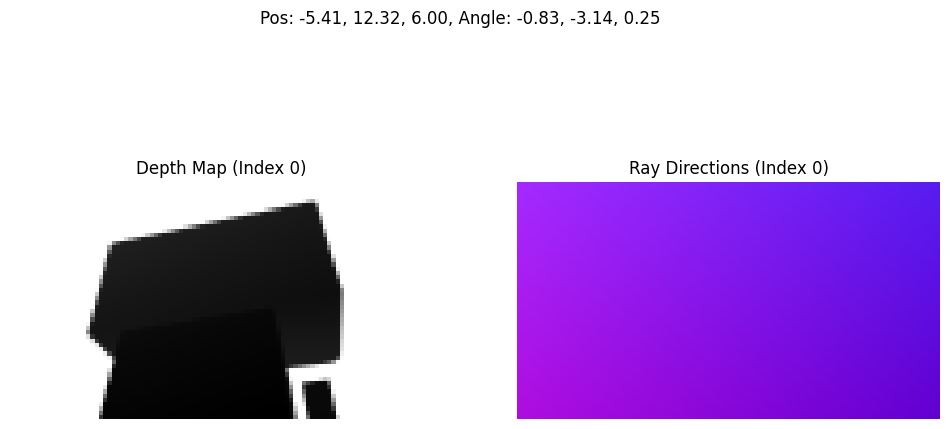

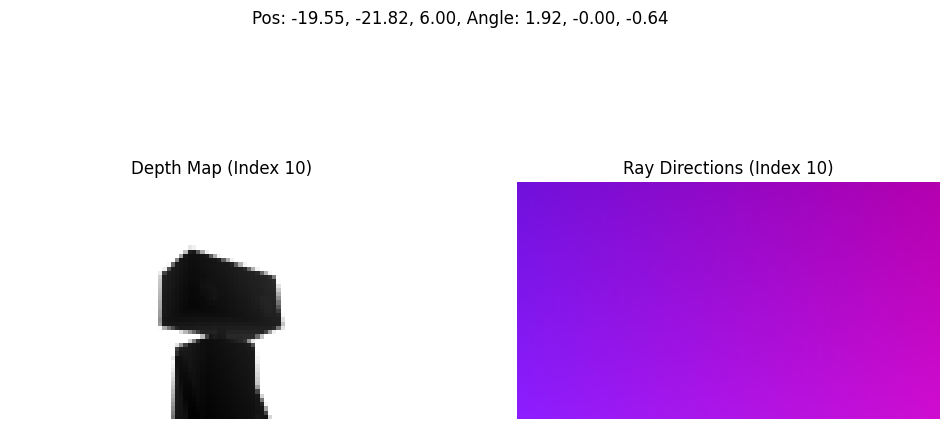

In [15]:
display_every = 10
for idx, data in dataset.items():
    if idx % display_every == 0:
        depth_image = data[DEPTH_MAP_ENTRY]
        ray_origins = data[RAYS_ENTRY][RAY_ORIGINS_ENTRY]
        ray_directions = data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY]
        camera_pos = data[CAMERA_POS_ENTRY]
        camera_angle = data[CAMERA_ANGLE_ENTRY]

        # Normalize rays for RGB visualization
        ray_rgb = (ray_directions - ray_directions.min()) / (ray_directions.max() - ray_directions.min())

        # Create a 2x1 plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Depth map
        axes[0].imshow(depth_image, cmap='gray')
        axes[0].set_title(f"Depth Map (Index {idx})")
        axes[0].axis('off')

        # Ray directions as RGB
        axes[1].imshow(ray_rgb.numpy())
        axes[1].set_title(f"Ray Directions (Index {idx})")
        axes[1].axis('off')

        # plt.suptitle(f"Camera Pos: {camera_pos}, Angle: {camera_angle}")
        # Format the camera angle to two decimal places
        formatted_angle = ', '.join([f"{angle:.2f}" for angle in camera_angle])
        formatted_pos = ', '.join([f"{pos:.2f}" for pos in camera_pos])

        # Update the plot title
        plt.suptitle(f"Pos: {formatted_pos}, Angle: {formatted_angle}")
        plt.show()

In [16]:
# Pre-pass function to filter depth and corresponding ray data
def sort_and_filter_depth_map(depth_map, ray_origins, ray_directions):
    # Flatten depth map and corresponding rays
    depth_flat = depth_map.flatten()
    ray_origins_flat = ray_origins.reshape(-1, 3)
    ray_directions_flat = ray_directions.reshape(-1, 3)

    # Validate shapes
    if len(depth_flat) != len(ray_origins_flat) or len(depth_flat) != len(ray_directions_flat):
        raise ValueError(f"Shape mismatch: depth {len(depth_flat)}, rays {len(ray_origins_flat)}")

    # Find maximum depth
    far_thresh = np.max(depth_flat)

    # Filter out max depth values
    valid_mask = depth_flat < far_thresh
    valid_indices = np.where(valid_mask)[0]

    # Calculate and print the percentage of sorted-out values
    removed_percentage = 100 * (len(depth_flat) - len(valid_indices)) / len(depth_flat)
    print(f"Percentage of filtered-out values: {removed_percentage:.2f}%")

    # Extract corresponding valid data
    filtered_depth = depth_flat[valid_indices]
    filtered_ray_origins = ray_origins_flat[valid_indices]
    filtered_ray_directions = ray_directions_flat[valid_indices]

    # Compute 2D indices
    height, width = depth_map.shape
    valid_2d_indices = np.column_stack(np.unravel_index(valid_indices, (height, width)))

    return filtered_depth, filtered_ray_origins, filtered_ray_directions, valid_indices, valid_2d_indices

# Post-process dataset to sort and filter depth maps
def post_process_dataset(dataset):
    print("Post-processing dataset...")

    for index, entry in dataset.items():
        try:
            # Store old values (for reconstruction)
            dataset[index]["OLD" + DEPTH_MAP_ENTRY] = dataset[index][DEPTH_MAP_ENTRY]
            dataset[index]["OLD" + RAYS_ENTRY] = {}
            dataset[index]["OLD" + RAYS_ENTRY][RAY_ORIGINS_ENTRY] =  dataset[index][RAYS_ENTRY][RAY_ORIGINS_ENTRY]
            dataset[index]["OLD" + RAYS_ENTRY][RAY_DIRECTIONS_ENTRY] =  dataset[index][RAYS_ENTRY][RAY_DIRECTIONS_ENTRY]
            dataset[index]["OLD" + CAMERA_POS_ENTRY] = dataset[index][CAMERA_POS_ENTRY]

            # Extract depth map and ray data
            depth_map = entry[DEPTH_MAP_ENTRY]
            ray_origins = entry[RAYS_ENTRY][RAY_ORIGINS_ENTRY]
            ray_directions = entry[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY]

            # Apply sorting and filtering
            sorted_depth, sorted_ray_origins, sorted_ray_directions, valid_indices, valid_2D_indices = sort_and_filter_depth_map(depth_map, ray_origins, ray_directions)

            # Update dataset entry
            dataset[index][DEPTH_MAP_ENTRY] = sorted_depth / 10.0
            dataset[index][RAYS_ENTRY][RAY_ORIGINS_ENTRY] = sorted_ray_origins / 10.0
            dataset[index][RAYS_ENTRY][RAY_DIRECTIONS_ENTRY] = sorted_ray_directions
            dataset[index][CAMERA_POS_ENTRY] = dataset[index][CAMERA_POS_ENTRY] / 10.0
            dataset[index][VALID_INDICES_ENTRY] = valid_indices
            dataset[index][VALID_2D_INDICES_ENTRY] = valid_2D_indices
        except Exception as e:
            print(f"Error processing index {index}: {e}")

    print("Post-processing complete!")
    return dataset


# Apply post-processing
dataset = post_process_dataset(dataset)

Post-processing dataset...
Percentage of filtered-out values: 53.43%
Percentage of filtered-out values: 83.48%
Percentage of filtered-out values: 83.02%
Percentage of filtered-out values: 82.66%
Percentage of filtered-out values: 81.68%
Percentage of filtered-out values: 75.00%
Percentage of filtered-out values: 63.77%
Percentage of filtered-out values: 52.62%
Percentage of filtered-out values: 62.07%
Percentage of filtered-out values: 72.73%
Percentage of filtered-out values: 76.07%
Percentage of filtered-out values: 78.88%
Percentage of filtered-out values: 81.36%
Percentage of filtered-out values: 82.88%
Percentage of filtered-out values: 83.77%
Percentage of filtered-out values: 83.98%
Post-processing complete!


## Train !

### Sphere tracing
This method renders a depth map using the model's predictions to dynamically adjust step size during ray marching.

In [17]:
def render_depth_sphere_tracing(
    distance_field_model: torch.nn.Module,
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    depth_map: torch.Tensor, # TODO: remove param, no longer useful
    near_thresh: float,
    max_iterations: int = 50,
) -> torch.Tensor:

    # Create a tensor to track active rays
    active_mask = torch.ones_like(depth_map, dtype=torch.bool) # TODO: use ray_origins shape instead of depth_map

    # Predicted depth map
    dstTravelled = torch.full_like(depth_map, 0, requires_grad=True) # TODO: use ray_origins shape instead of depth_map
    steps = torch.zeros_like(active_mask, dtype=torch.float32, requires_grad=True)
    
    all_query_points = []
    all_predicted_distances = []

    for i in range(max_iterations):
        # Stop if no active rays remain
        if not torch.any(active_mask):
            break
        
        # Compute the query points
        query_points = ray_origins + ray_directions * dstTravelled[..., None]
        query_points.requires_grad_()
        
        # Predict distances using the model
        predicted_distances = distance_field_model(query_points).squeeze(-1)
        
        # Increment the steps for active rays
        steps = torch.where(active_mask, steps + 1, steps)

        # Mask for rays that are within the surface threshold
        hit_mask = ((predicted_distances < near_thresh) | (dstTravelled >= depth_map)) & active_mask

        # Estimate distance for rays that have hit
        if (dstTravelled >= depth_map).any():
            # select firsst ray that has hit
            hit_index = torch.where(dstTravelled >= depth_map)[0][0]
            hit_point = query_points[hit_index]
            estimate_distance(hit_point, dataset, device)
            print(f"Hit point: {hit_point}")
            print(f"Hit direction: {ray_directions[hit_index]}")
            print(f"Hit distance: {dstTravelled[hit_index]}")
            print(f"Hit origin: {ray_origins[hit_index]}")
            break

        # Store active query points and predictions
        all_query_points.append(query_points[~hit_mask])
        all_predicted_distances.append(predicted_distances[~hit_mask])

        # Update active mask to deactivate rays that hit
        active_mask = active_mask & ~hit_mask
        
        # Update the depth map only for rays that have hit
        dstTravelled = torch.where(active_mask, dstTravelled + predicted_distances, dstTravelled)

    # Concatenate query points and distances
    all_query_points = torch.cat(all_query_points, dim=0)
    all_predicted_distances = torch.cat(all_predicted_distances, dim=0)

    return dstTravelled, steps, all_query_points, all_predicted_distances

### Eikonal loss function

In [18]:
def compute_gradients(model, query_points, eps=1e-4, sample_ratio=0.1):
    """
    Computes numerical gradients of SDF using finite differences.

    Args:
    - model: The implicit function.
    - query_points: Tensor of shape [N, 3], query points.
    - eps: Small step for finite differences.
    - sample_ratio: Fraction of points to sample for gradient computation.

    Returns:
    - gradients: Tensor of shape [sampled_N, 3], computed gradients.
    """
    N = query_points.shape[0]
    device = query_points.device

    # Randomly sample query points
    nb_samples = min(int(N * sample_ratio), 5000)
    sampled_indices = torch.randperm(N, device=device)[:nb_samples]
    sampled_points = query_points[sampled_indices]

    # Allocate memory for gradients
    gradients = torch.zeros_like(sampled_points, device=device)

    for i in range(3):  # Compute gradient w.r.t x, y, z
        offset = torch.zeros_like(sampled_points, device=device)
        offset[:, i] = eps

        forward_points = sampled_points + offset
        backward_points = sampled_points - offset

        forward_sdf = model(forward_points).squeeze(-1)
        backward_sdf = model(backward_points).squeeze(-1)

        # Central finite difference
        gradients[:, i] = (forward_sdf - backward_sdf) / (2 * eps)

    return gradients

def compute_eikonal_loss(gradients):
    """
    Computes the Eikonal loss using the computed gradients.

    Args:
    - gradients (torch.Tensor): Tensor of shape [N, 3] containing the gradients of SDF predictions.

    Returns:
    - loss (torch.Tensor): Computed Eikonal loss.
    """
    # ||grad|| should be close to 1, compute the deviation from 1
    loss = torch.mean(torch.abs(torch.norm(gradients, dim=-1) - 1))
    return loss

### Checkpoint saving and loading

In [19]:
# Checkpoint saving function
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    # print(f"Checkpoint saved at {checkpoint_path}")

# Checkpoint loading function
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Loaded checkpoint from {checkpoint_path}: Epoch {epoch}, Loss: {loss:.4f}")
        return epoch, loss
    else:
        print(f"No checkpoint found at {checkpoint_path}")
        return 0, float('inf')

### Training loop

In [20]:
import os
import torch
import random

# Learning parameters
L = 5
lr = 1e-5

# Model and optimizer
model = NeDFModel(L=L).to(device)
model.apply(initialize_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Seed RNG
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Load previous checkpoint if available
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
start_epoch, best_loss = load_checkpoint(model, optimizer, os.path.join(checkpoint_dir, CHECKPOINT_NAME))

Loaded checkpoint from checkpoints\checkpoint.pth: Epoch 0, Loss: 4.3011


C:\Users\Alex\AppData\Local\Temp\ipykernel_14688\2145384047.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [21]:
# Test model with random points
with torch.no_grad():
    scale = 100
    test_points = torch.rand(1000, 3, device=device) * scale - torch.tensor([scale/2, scale/2, scale/2], device=device)
    # predicted_distances = model(test_points).squeeze(-1).detach().cpu().numpy()
    for test_point in test_points:
        estimate_distance(test_point, dataset, device)

Estimated distance (tensor([ 22.5777,  14.0074, -19.3583], device='cuda:0')): inf
Estimated distance (tensor([-43.1113, -42.0344, -44.9225], device='cuda:0')): inf
Estimated distance (tensor([-47.6171,  -9.8466, -28.0428], device='cuda:0')): inf
Estimated distance (tensor([-40.8866,  48.8191, -44.3285], device='cuda:0')): inf
Estimated distance (tensor([36.1431, -2.7451,  4.6711], device='cuda:0')): inf
Estimated distance (tensor([ 15.8851, -35.6392, -34.1715], device='cuda:0')): inf


IndexError: tuple index out of range

C:\Users\Alex\AppData\Local\Temp\ipykernel_14688\3221760534.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_origins = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)
C:\Users\Alex\AppData\Local\Temp\ipykernel_14688\3221760534.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_directions = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)


Estimated distance (tensor([-0.0319,  0.5114, -2.3742], device='cuda:0', grad_fn=<SelectBackward0>)): inf
Hit point: tensor([-0.0319,  0.5114, -2.3742], device='cuda:0', grad_fn=<SelectBackward0>)
Hit direction: tensor([ 0.0583, -0.4912, -0.8802], device='cuda:0')
Hit distance: 1.0081961154937744
Hit origin: tensor([-0.0907,  1.0066, -1.4868], device='cuda:0')


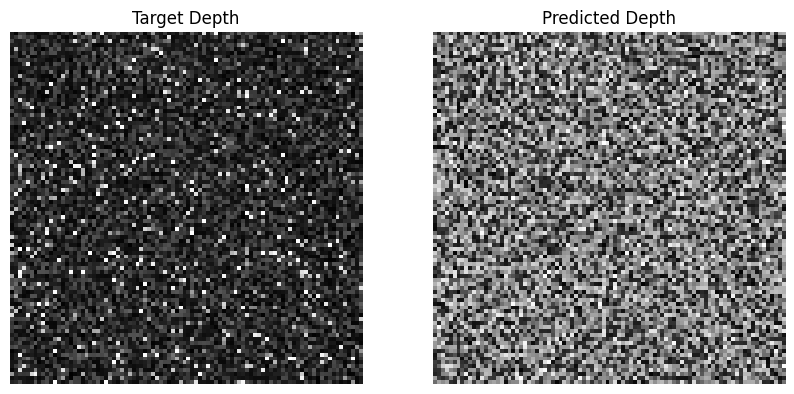


### Step 0 ###
Average distance: 0.45
Average steps: 3.00
Total loss: 4.30 (Depth: 1.97, Eikonal: 0.83, Exceed: 0.00)
Best loss: 4.53
Training complete!


In [11]:
# Training parameters
display_every = 1
plot_every = 1
save_every = 50  # Save every n iterations
batch_size = 1024*8  # Number of rays per batch

exceed_depth_threshold = 1.2  # Factor threshold for exceeding sampled depth
max_ray_marching_steps = 10

# Loss weights
exceed_depth_threshold = 1.1
exceed_depth_penalty_weight = 1
eikonal_penalty_weight = 1
depth_penalty_weight = 1
steps_penalty_weight = 5

num_iters = start_epoch + 1 # Change this here for longer sessions
near_thresh = 0.01

# Training Loop
for i in range(start_epoch, num_iters):
    # Sample random dataset indices
    indices = torch.randint(0, len(dataset), (batch_size,))
    # Extract data for all sampled indices
    data_batch = [list(dataset.values())[idx] for idx in indices.cpu().numpy()]

    # Flatten ray and depth arrays for uniform sampling
    target_depth = torch.cat([torch.tensor(data[DEPTH_MAP_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)
    ray_origins = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)
    ray_directions = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)

    # Convert to GLM coordinates
    ray_origins = blender_to_opengl(ray_origins).to(device)
    ray_directions = blender_to_opengl(ray_directions).to(device)

    # Sample random pixel coordinates from the flattened array
    rand_coords = torch.randint(0, target_depth.shape[0], (batch_size,))

    # Gather samples
    sampled_depth = target_depth[rand_coords]
    sampled_ray_origins = ray_origins[rand_coords]
    sampled_ray_directions = ray_directions[rand_coords]

    # Ensure there are valid samples left after sampling
    if sampled_ray_origins.shape[0] == 0:
        print("No valid samples found, skipping this batch.")
        continue

    # Perform sphere tracing
    depth_predicted, steps, query_points, query_results = render_depth_sphere_tracing(
        model, sampled_ray_origins, sampled_ray_directions, sampled_depth, near_thresh, max_ray_marching_steps
    )

    # Correctly reshape to the largest possible square
    valid_size = int(torch.sqrt(torch.tensor(sampled_depth.shape[0], dtype=torch.float32)).floor().item())
    reshaped_predicted = depth_predicted[:valid_size**2].view(valid_size, valid_size).detach().cpu().numpy()
    reshaped_target = sampled_depth[:valid_size**2].view(valid_size, valid_size).detach().cpu().numpy()

    # Display predicted vs target depth
    if i % plot_every == 0:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(reshaped_target, cmap='gray')
        axes[0].set_title("Target Depth")
        axes[0].axis('off')

        axes[1].imshow(reshaped_predicted, cmap='gray')
        axes[1].set_title("Predicted Depth")
        axes[1].axis('off')
        plt.show()

    # Combine Losses
    average_steps = steps.mean()
    steps_loss = average_steps / max_ray_marching_steps 

    gradients = compute_gradients(model, query_points)
    eikonal_loss = compute_eikonal_loss(gradients)

    exceed_depth_diff = torch.clamp(depth_predicted - sampled_depth * exceed_depth_threshold, min=0)
    exceed_depth_loss = exceed_depth_diff.mean()

    depth_loss = torch.nn.functional.mse_loss(depth_predicted, sampled_depth)
    total_loss = depth_loss * depth_penalty_weight
    total_loss = total_loss + eikonal_loss * eikonal_penalty_weight
    total_loss = total_loss + exceed_depth_loss * exceed_depth_penalty_weight
    total_loss = total_loss + steps_loss * steps_penalty_weight

    if (total_loss == float('inf') or total_loss == float('nan')):
        print("Loss is infinite or NaN, skipping this batch.")
        continue

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display Progress
    if i % display_every == 0:
        print(f"\n### Step {i} ###")
        print(f"Average distance: {query_results.mean().item():.2f}")
        print(f"Average steps: {steps.mean().item():.2f}")
        print(f"Total loss: {total_loss.item():.2f} (Depth: {depth_loss.item():.2f}, Eikonal: {eikonal_loss.item():.2f}, Exceed: {exceed_depth_loss.item():.2f})")
        print(f"Best loss: {best_loss:.2f}")

    # Save checkpoint periodically or if loss improves
    if i % save_every == 0 or total_loss.item() < best_loss:
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
        save_checkpoint(model, optimizer, i, total_loss.item(), os.path.join(checkpoint_dir, CHECKPOINT_NAME))

print("Training complete!")

## Inference

In [12]:
# Model and optimizer
L = 5
model = NeDFModel(L=L).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Load checkpoint
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
start_epoch, best_loss = load_checkpoint(model, optimizer, os.path.join(checkpoint_dir, CHECKPOINT_NAME))

Loaded checkpoint from checkpoints\checkpoint.pth: Epoch 0, Loss: 4.5318


C:\Users\Alex\AppData\Local\Temp\ipykernel_22536\2145384047.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


### Testing on train dataset

In [13]:
for i in range(DATASET_SIZE//4):
    # Select one dataset entry
    data_entry = dataset[i]

    # Extract old depth and ray data
    old_target_depth = torch.tensor(data_entry["OLD" + DEPTH_MAP_ENTRY], dtype=torch.float32, device=device)
    old_ray_origins = torch.tensor(data_entry["OLD" + RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32, device=device)
    old_ray_directions = torch.tensor(data_entry["OLD" + RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32, device=device)

    # Perform inference on full data
    width, height = old_ray_origins.shape[1], old_ray_origins.shape[0]
    predicted_depth, _, _, _ = render_depth_sphere_tracing(
        model, old_ray_origins, old_ray_directions, old_target_depth, near_thresh
    )

    # Initialize full depth maps with placeholder
    width, height = old_ray_origins.shape[1], old_ray_origins.shape[0]
    full_predicted_depth = predicted_depth.view(-1).clone()
    full_target_depth = old_target_depth.view(-1).clone()

    # Reshape to 2D
    full_predicted_depth = full_predicted_depth.view(height, width)
    full_target_depth = full_target_depth.view(height, width)

    # Display predicted vs target depth
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(full_target_depth.detach().cpu().numpy(), cmap='gray')
    axes[0].set_title("Target Depth")
    axes[0].axis('off')

    axes[1].imshow(full_predicted_depth.detach().cpu().numpy(), cmap='gray')
    axes[1].set_title("Predicted Depth")
    axes[1].axis('off')
    plt.show()


NameError: name 'DATASET_SIZE' is not defined

### Tesing on new camera angles

Ideally we would separate the dataset in two test / train sets instead of using new orientations. That way we could compute the loss numerically on top of observing the visual difference. 

C:\Users\Alex\AppData\Local\Temp\ipykernel_15664\193090257.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_pos1 = torch.tensor(data_entry1[CAMERA_POS_ENTRY], dtype=torch.float32, device=device)
C:\Users\Alex\AppData\Local\Temp\ipykernel_15664\193090257.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_pos2 = torch.tensor(data_entry2[CAMERA_POS_ENTRY], dtype=torch.float32, device=device)
C:\Users\Alex\AppData\Local\Temp\ipykernel_15664\193090257.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_dir1 = torch.tensor(data

Interpolating between indices 0 and 1...
pos1: -0.54, 1.23, 0.60, pos2: 0.22, 1.08, 0.60, interpolated: -0.16, 1.16, 0.60
dir1: -0.83, -3.14, 0.25, dir2: -0.80, -3.14, -0.47, interpolated: -0.82, -3.14, -0.11


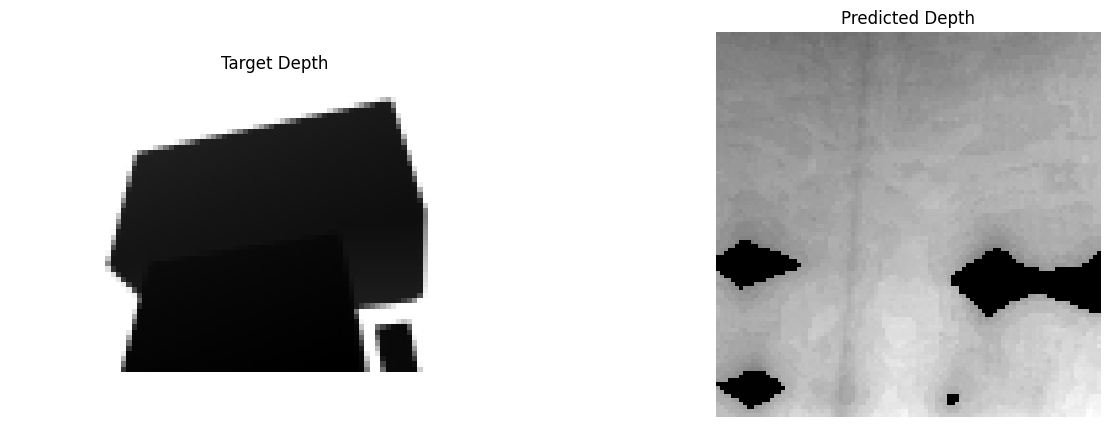

Interpolating between indices 1 and 2...
pos1: 0.22, 1.08, 0.60, pos2: 0.87, 0.65, 0.60, interpolated: 0.55, 0.86, 0.60
dir1: -0.80, -3.14, -0.47, dir2: 2.27, 0.00, 2.01, interpolated: 0.73, -1.57, 0.77


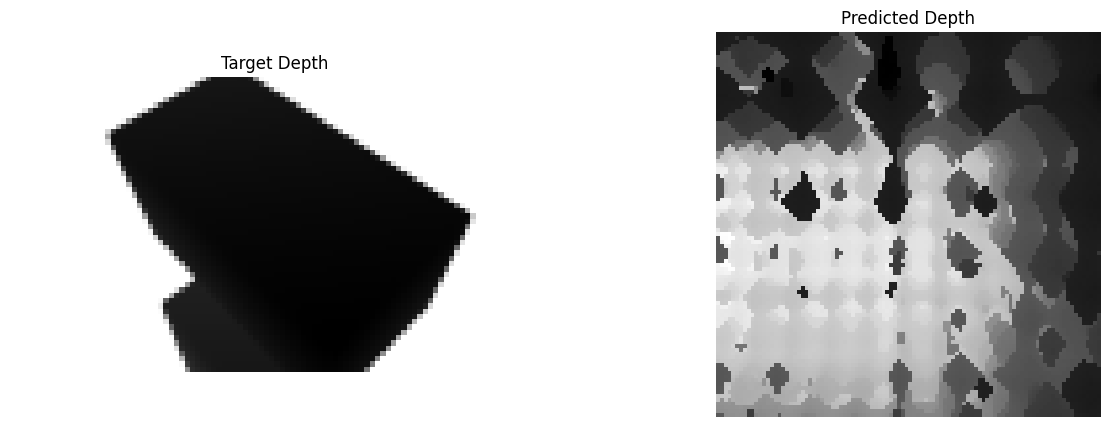

Interpolating between indices 2 and 3...
pos1: 0.87, 0.65, 0.60, pos2: 1.31, -0.00, 0.60, interpolated: 1.09, 0.32, 0.60
dir1: 2.27, 0.00, 2.01, dir2: 2.16, -0.00, 1.49, interpolated: 2.21, 0.00, 1.75


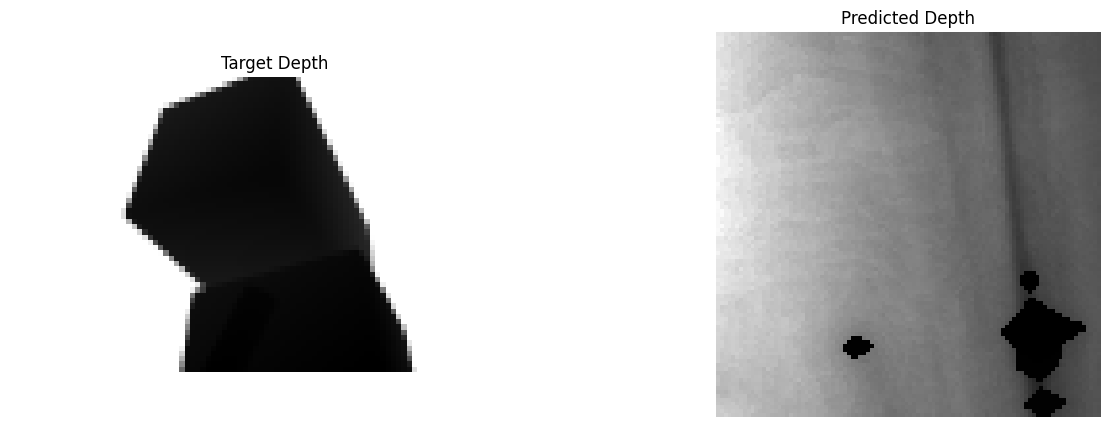

Interpolating between indices 3 and 4...
pos1: 1.31, -0.00, 0.60, pos2: 1.46, -0.77, 0.60, interpolated: 1.38, -0.39, 0.60
dir1: 2.16, -0.00, 1.49, dir2: 2.07, 0.00, 1.10, interpolated: 2.11, -0.00, 1.30


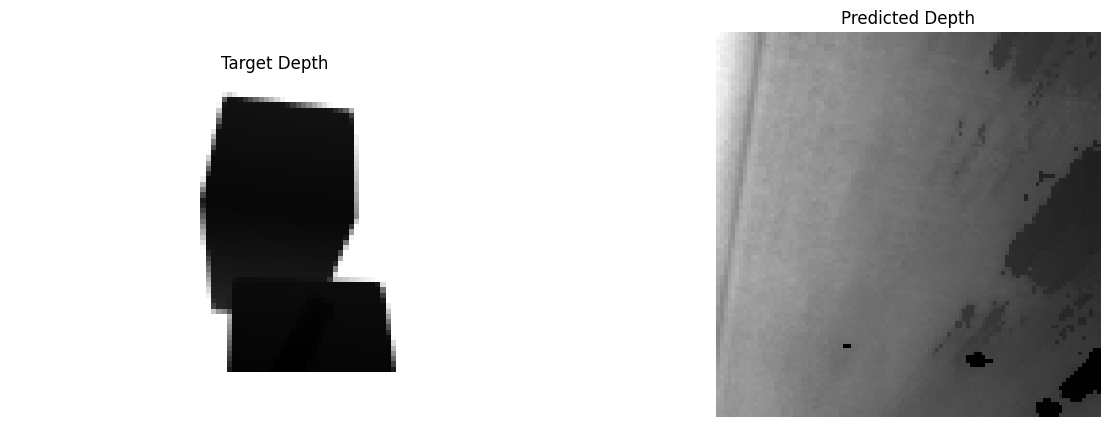

In [18]:
for i in range(DATASET_SIZE//4):
    # Interpolate between two camera positions
    data_entry1 = dataset[i]
    data_entry2 = dataset[i + 1]

    cam_pos1 = torch.tensor(data_entry1[CAMERA_POS_ENTRY], dtype=torch.float32, device=device)
    cam_pos2 = torch.tensor(data_entry2[CAMERA_POS_ENTRY], dtype=torch.float32, device=device)

    # Interpolation factor
    alpha = 0.5
    interpolated_cam_pos = cam_pos1 * (1 - alpha) + cam_pos2 * alpha

    # Interpolate camera angles
    cam_dir1 = torch.tensor(data_entry1[CAMERA_ANGLE_ENTRY], dtype=torch.float32, device=device)
    cam_dir2 = torch.tensor(data_entry2[CAMERA_ANGLE_ENTRY], dtype=torch.float32, device=device)
    interpolated_cam_dir = cam_dir1 * (1 - alpha) + cam_dir2 * alpha

    # Generate new rays using the ray generation function
    width, height = 100, 100
    focal_length = fov_to_focal_length(FOV, width)
    tform_cam2world = pos_angle_to_tform_cam2world(interpolated_cam_pos, interpolated_cam_dir)
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, tform_cam2world)
    ray_origins = ray_origins.to(device)
    ray_directions = ray_directions.to(device)

    # Perform inference
    infinite_depth_map = torch.full((height, width), 10000.0, device=device) # Needed in sphere tracing to let rays go as far as they want
    predicted_depth, _, _, _ = render_depth_sphere_tracing(
        model, ray_origins, ray_directions, infinite_depth_map, near_thresh
    )

    # Reshape and visualize
    predicted_depth_2d = predicted_depth.view(height, width)

    # Extract target depth for comparison from first entry
    target_depth_2d = torch.tensor(data_entry1["OLD" + DEPTH_MAP_ENTRY], dtype=torch.float32, device=device)

    # Display predicted vs target depth
    formatted_pos1 = ', '.join([f"{pos:.2f}" for pos in cam_pos1])
    formatted_pos2 = ', '.join([f"{pos:.2f}" for pos in cam_pos2])
    formatted_interpolated_cam_pos = ', '.join([f"{pos:.2f}" for pos in interpolated_cam_pos])
    formatted_dir1 = ', '.join([f"{dir:.2f}" for dir in cam_dir1])
    formatted_dir2 = ', '.join([f"{dir:.2f}" for dir in cam_dir2])
    formatted_interpolated_cam_dir = ', '.join([f"{dir:.2f}" for dir in interpolated_cam_dir])

    print(f"Interpolating between indices {i} and {i + 1}...")
    print(f"pos1: {formatted_pos1}, pos2: {formatted_pos2}, interpolated: {formatted_interpolated_cam_pos}")
    print(f"dir1: {formatted_dir1}, dir2: {formatted_dir2}, interpolated: {formatted_interpolated_cam_dir}")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(target_depth_2d.detach().cpu().numpy(), cmap='gray')
    axes[0].set_title("Target Depth")
    axes[0].axis('off')

    axes[1].imshow(predicted_depth_2d.detach().cpu().numpy(), cmap='gray')
    axes[1].set_title("Predicted Depth")
    axes[1].axis('off')
    plt.show()

